### **Setup Environment, Compile C++ Codes, and Import Dependencies**

This assignment requires us to understand and apply traditional image processing techniques. Considering the efficiency of pixel traversal, I plan to use C++ as the main language and then package it into a Python package to provide an API for use in a Python notebook. I am using the third-party library pybind11 to package the C++ code. If the packaging doesn’t work, you can place the provided package in the modules folder; this package is simply a compilation of the C++ code under the scripts directory.

In [1]:
# Run the compiler
!python compile.py

running build_ext
copying build\lib.win-amd64-cpython-312\image_processing.cp312-win_amd64.pyd -> 
Removed existing file: modules\image_processing.cp312-win_amd64.pyd
Moved image_processing.cp312-win_amd64.pyd to modules

Success!


In [2]:
# All Imports
from modules import *

### **Image Processing**

Before proceeding with image processing, I encapsulated an `Image` class to store information about the image, including its height, width, bytes per pixel, raw data, and so on. I then specified that the methods for image processing must be static and return a new image to ensure that the original image information remains unchanged. This principle will always apply: the image's data is read-only and cannot be modified.

For detailed API information, please refer to the `README.md` file.

---

#### **[Problem 1: Getting Started]**

- **Gray Scale**

    In daily life, we often hear about black-and-white photos and color photos. In class, I learned that the brightness (grayscale) of a color photo can be calculated using the following formula:

    $$
    Y = 0.299 \times R + 0.587 \times G + 0.114 \times B
    $$

    After loading a color photo, I calculated its brightness (grayscale) using the formula above and saved it to a new image, achieving the following effect. This effect is quite good. Although the image has been converted to grayscale, the overall characteristic features have been preserved.


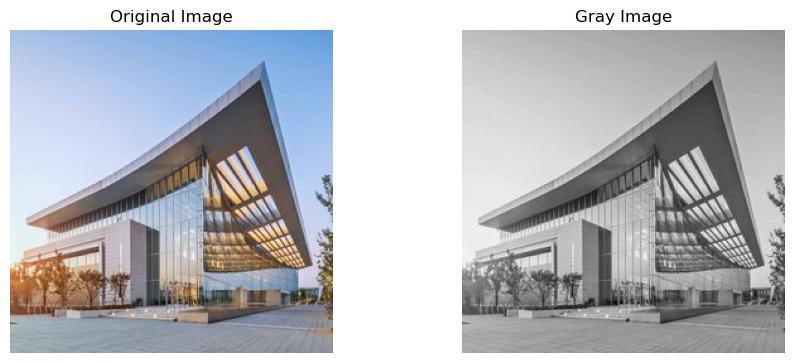

In [3]:
# Gray Scale
AB_img = Image(256, 256, 3)
AB_img.load("images/building2_color.raw")
AB_img_gray = Image.gray_scale(AB_img)

show_images([AB_img, AB_img_gray], ["Original Image", "Gray Image"])

- **Water Mark**

    In daily life, we often see watermarks in front of many images, which are used to increase their visibility. This effect is achieved through image overlay. I start with two images: a background image and a watermark image. Then, I specify the offset for the height and width (with the origin at the top-left corner) to inform the CPU where to begin drawing the watermark. I also provide a `blend_rate` value to tell the CPU how to blend the watermark with the background image (with `blend_rate` ranging from 1 to 0 representing completely visible to completely invisible). Finally, I give a threshold value to inform the CPU what level of brightness in the color should be considered as the background to be removed. This way, we can extract the important parts of the watermark image and blend them into a specific location on the background image.


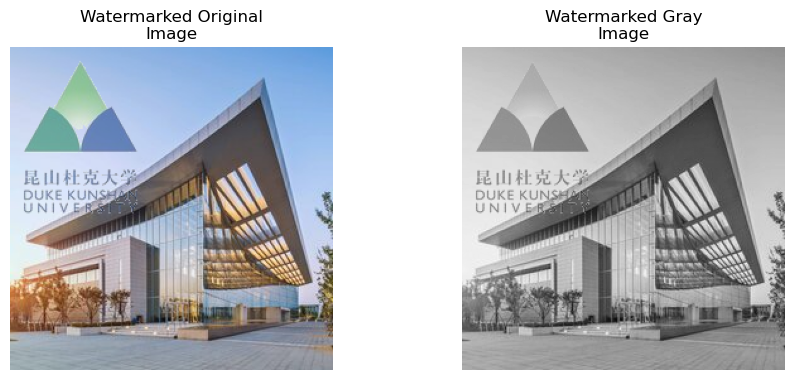

In [4]:
# Watermark
dku_logo = Image(128, 128, 3)
dku_logo.load("images/dku_logo_color.raw")
AB_img_with_logo = Image.water_mark(AB_img, dku_logo, -10, 10, 220, 0.5)

dku_logo_gray = Image(128, 128, 1)
dku_logo_gray.load("images/dku_logo_gray.raw")
watermarked_gray_img = Image.water_mark(AB_img_gray, dku_logo_gray, -10, 10, 220, 0.5)

show_images([AB_img_with_logo, watermarked_gray_img], ["Watermarked Original Image", "Watermarked Gray Image"])

- **Negative Image**

    When I watch online videos, due to certain restrictions, some graphic violent content is sometimes color-inverted by the video authors to pass the review. In this case, we often see peculiar effects, such as blood turning green. The principle behind this is quite simple: by applying the following formula to invert the color for each channel:

    $$
    \text{Negative Image} = 255 - \text{Original Image}
    $$

    We can then compare the colors of the two images. Below, I have plotted the histograms of the RGB channels for both images (using the API I encapsulated; for details, see the `plot.py` file in the `modules` folder) to facilitate the comparison of effects. I can see that for each channel, the color histogram of the inverted image is symmetrical to that of the original image (after all, it is 255 minus the original).


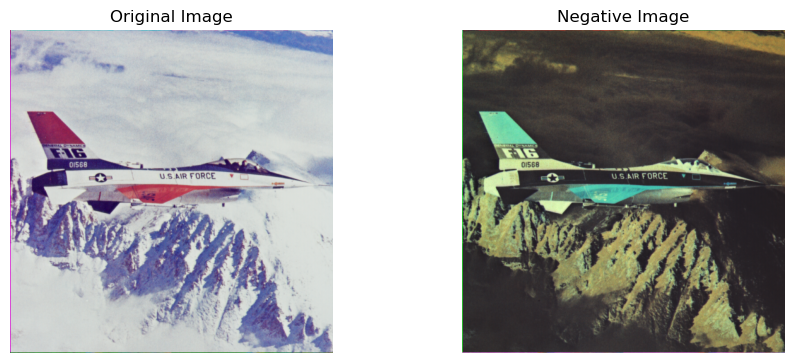

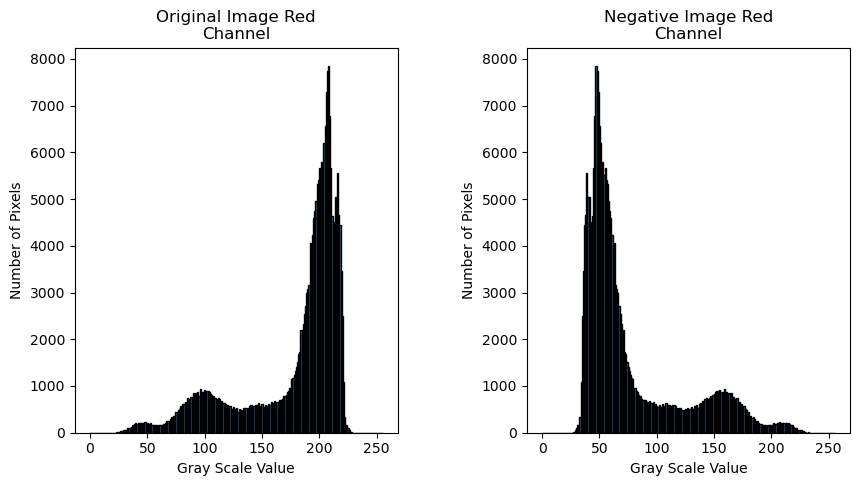

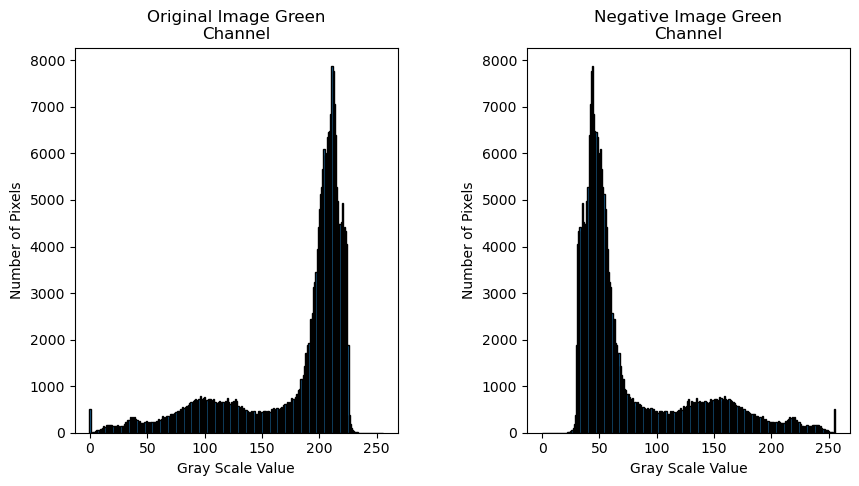

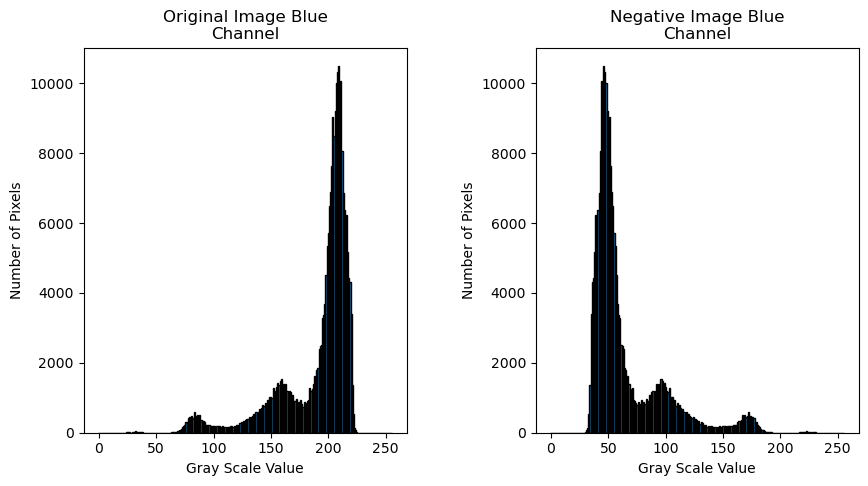

In [5]:
# Negative Image
F_16_img = Image(512, 512, 3)
F_16_img.load("images/F-16.raw")
F_16_img_negative = Image.negative(F_16_img)

show_images([F_16_img, F_16_img_negative], ["Original Image", "Negative Image"])
plot_histograms([F_16_img, F_16_img_negative], ["Original Image Red Channel", "Negative Image Red Channel"], [0, 0])
plot_histograms([F_16_img, F_16_img_negative], ["Original Image Green Channel", "Negative Image Green Channel"], [1, 1])
plot_histograms([F_16_img, F_16_img_negative], ["Original Image Blue Channel", "Negative Image Blue Channel"], [2, 2])

#### **[Problem 2: Image Enhancement]**

- **Image Contrast Enhancement**

    Sometimes we find that the overall brightness of an image is too dark or too bright. This is likely because the brightness of most pixels is concentrated in a very small region. To address this, we can perform image enhancement to stretch them to a reasonable brightness level that is suitable for human observation. 

    In the following, I used the linear scale method, which, as the name suggests, linearly scales the pixels concentrated in one area to another region. In the example below, I stretched the brightness distribution to the full range of 0-255. Other distribution adjustments can be modified by changing the parameters. 
    $$
    I_{new} = \frac{(I_{old} - I_{min}) \times (new\_max - new\_min)}{(I_{max} - I_{min})} + new\_min
    $$
    By plotting the histogram, we can see that the original pixels are concentrated in a very small range of brightness levels. Through linear stretching, we expand them. I think the effect is quite good.


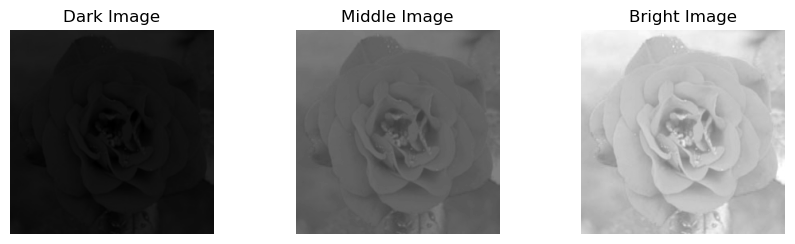

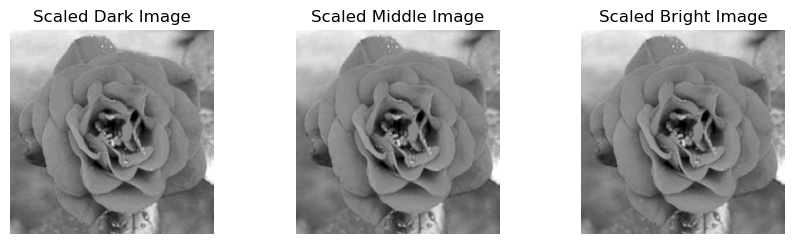

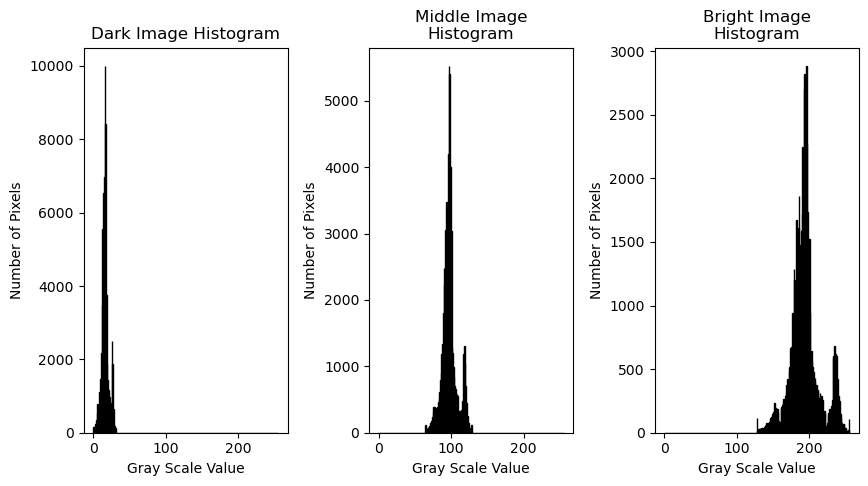

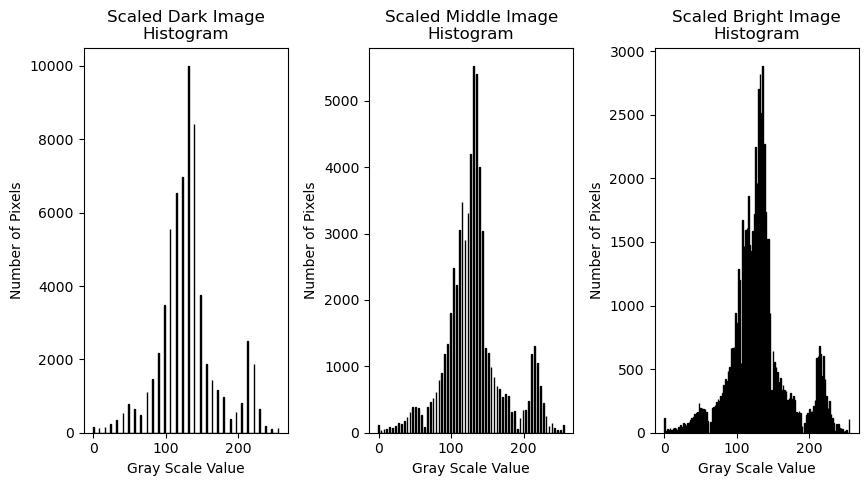

In [6]:
# Image Contrast Enhancement
rose_dark = Image(256, 256, 1)
rose_dark.load("images/rose_dark.raw")
rose_middle = Image(256, 256, 1)
rose_middle.load("images/rose_mid.raw")
rose_bright = Image(256, 256, 1)
rose_bright.load("images/rose_bright.raw")

rose_dark_scaled = Image.linear_scale(rose_dark, 0, 0, 255)
rose_middle_scaled = Image.linear_scale(rose_middle, 0, 0, 255)
rose_bright_scaled = Image.linear_scale(rose_bright, 0, 0, 255)

show_images([rose_dark, rose_middle, rose_bright], ["Dark Image", "Middle Image", "Bright Image"])
show_images([rose_dark_scaled, rose_middle_scaled, rose_bright_scaled], ["Scaled Dark Image", "Scaled Middle Image", "Scaled Bright Image"])
plot_histograms([rose_dark, rose_middle, rose_bright], ["Dark Image Histogram", "Middle Image Histogram", "Bright Image Histogram"])
plot_histograms([rose_dark_scaled, rose_middle_scaled, rose_bright_scaled], ["Scaled Dark Image Histogram", "Scaled Middle Image Histogram", "Scaled Bright Image Histogram"])

- **Histogram Equalization**

    For image enhancement, the main principle is to make the histogram of the image tend to a uniform distribution. In other words, its cumulative histogram should present a nearly linear increase. My implementation method is to split the histogram, which is originally concentrated together, into `bin_size` bins and then perform a separate linear mapping for each bin, mapping it to its corresponding linear cumulative coordinate range:

    $$
    h(v) = \mathrm{round} \left( \frac{\operatorname{cdf}(v) - \operatorname{cdf}_{\min}}{(M \times N) - \operatorname{cdf}_{\min}} \times (L - 1) \right)
    $$

    The detailed implementation effect is shown in the image below:
    <div style="text-align: center;">
    <img src="images/HE_enhance.jpg" alt="Implementation" width="400"/>
    </div>

    Based on the plotted histogram, we found that when `bin_size` is around 64 or greater, it generally converges, and the cumulative histogram presents a linear effect. The distribution of the histogram also becomes relatively uniform and close to uniformity. However, due to some brightness pixels having a count that is too high, resulting in equal adjacent min and max values (causing a denominator of 0), there are some local peaks. In such cases, my approach is to directly map these pixels to the mean of the `min` and `max` to prevent certain colors from being overly prominent. I am very satisfied with the enhancement results.

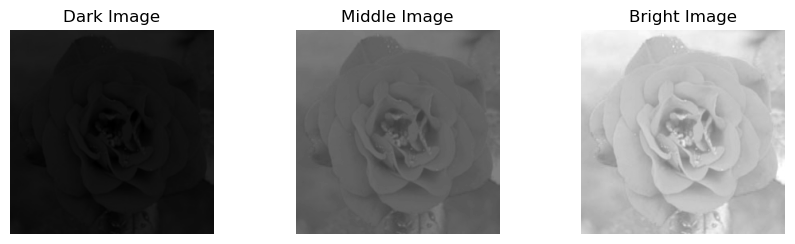

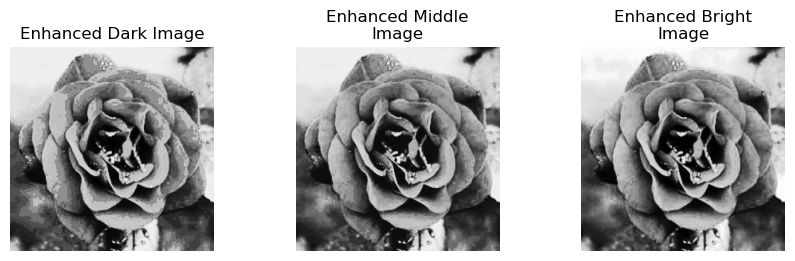

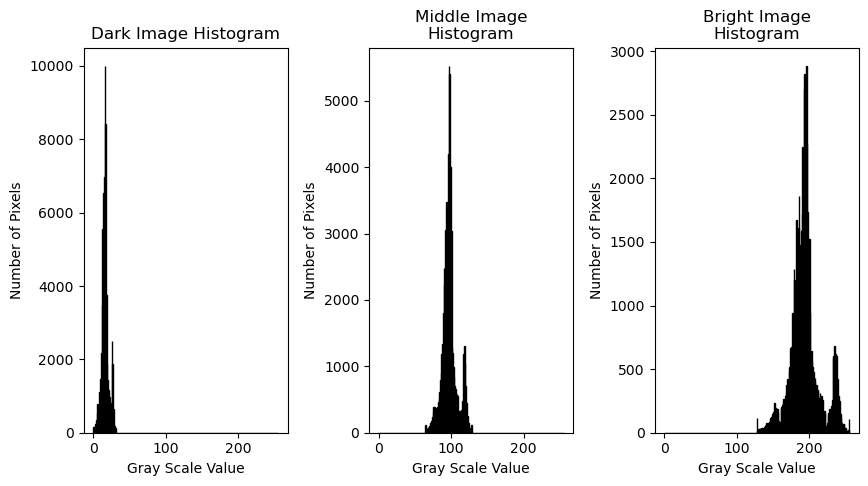

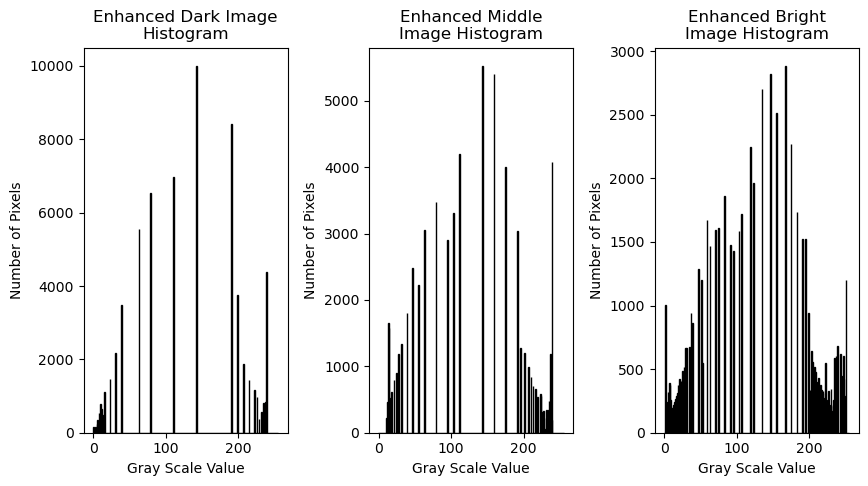

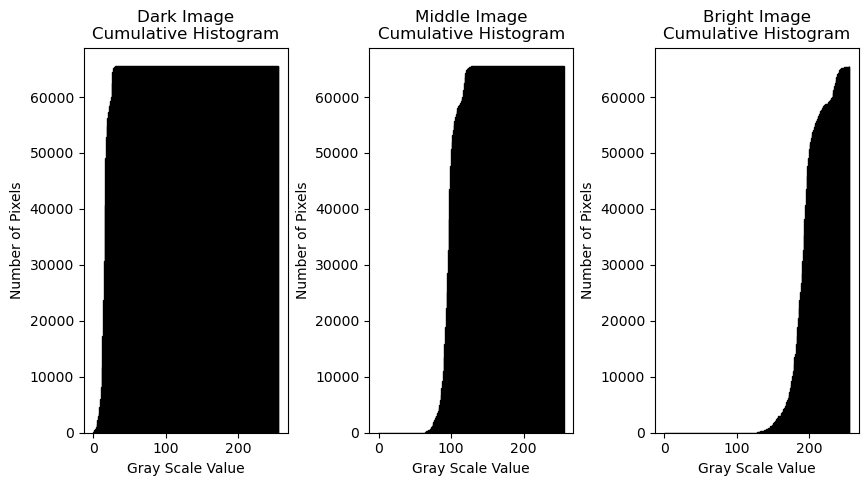

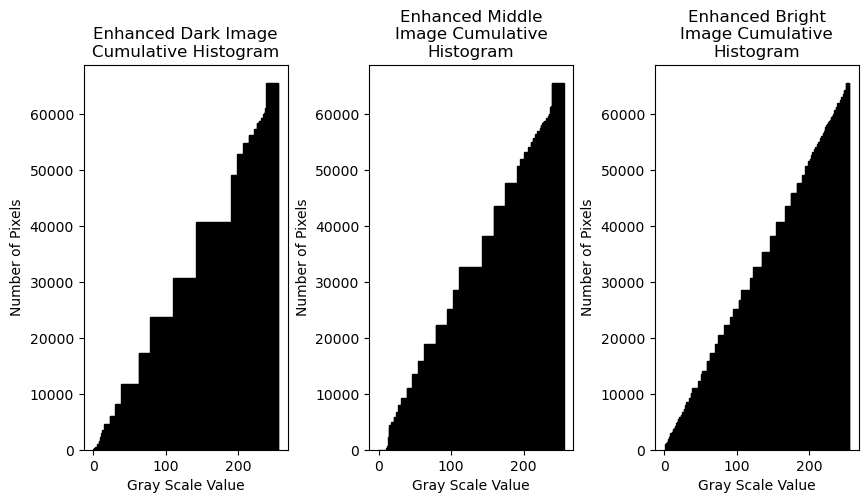

In [7]:
# Histogram Equalization

rose_dark_enhanced = Image.hist_equalize(rose_dark, 0, 16)
rose_middle_enhanced = Image.hist_equalize(rose_middle, 0, 16)
rose_bright_enhanced = Image.hist_equalize(rose_bright, 0, 64)

show_images([rose_dark, rose_middle, rose_bright], ["Dark Image", "Middle Image", "Bright Image"])
show_images([rose_dark_enhanced, rose_middle_enhanced, rose_bright_enhanced], ["Enhanced Dark Image", "Enhanced Middle Image", "Enhanced Bright Image"])
plot_histograms([rose_dark, rose_middle, rose_bright], ["Dark Image Histogram", "Middle Image Histogram", "Bright Image Histogram"])
plot_histograms([rose_dark_enhanced, rose_middle_enhanced, rose_bright_enhanced], ["Enhanced Dark Image Histogram", "Enhanced Middle Image Histogram", "Enhanced Bright Image Histogram"])
plot_histograms([rose_dark, rose_middle, rose_bright], ["Dark Image Cumulative Histogram", "Middle Image Cumulative Histogram", "Bright Image Cumulative Histogram"], cumulative=True)
plot_histograms([rose_dark_enhanced, rose_middle_enhanced, rose_bright_enhanced], ["Enhanced Dark Image Cumulative Histogram", "Enhanced Middle Image Cumulative Histogram", "Enhanced Bright Image Cumulative Histogram"], cumulative=True)

#### **[Problem 3: Noise Removal]**

- **Gray-level Image**

  In daily life, images often contain noise that affects their clarity and information. To address this, we can use low-pass filtering to reduce noise, as most of the time, noise is high-frequency information. This way, we can effectively obtain information from the denoised image. In this assignment, there are two types of noise: 1 is uniform noise, and 2 is Gaussian noise. I used different filtering methods for denoising:

  For uniform noise, I applied three different denoising methods:

  - **Mean Denoising**: This method takes the mean of the elements in the kernel window to serve as the value of the central element after convolution:

    $$
    I_{\text{new}}(x, y) = \frac{1}{N} \sum_{(i,j) \in \Omega} I(i, j)
    $$

  - **Median Denoising**: This method sorts the elements in the kernel window and takes the median of the sorted values to serve as the value of the central element after convolution:

    $$
    I_{\text{new}}(x, y) = \text{median}\left\{ I(i, j) \, | \, (i, j) \in \Omega \right\}
    $$

  - **Pseudo-Median Denoising**: This method sorts the elements in the kernel window and takes the mean of the maximum of the minima (maximin) and the minimum of the maxima (minimax) to serve as the value of the central element after convolution:

    $$
    I_{\text{new}}(x, y) = \text{Pmedian}\left\{ I(i, j) \, | \, (i, j) \in \Omega \right\}
    $$

    $$
    \text{Pmedian}\{S_L\} = \frac{1}{2} \cdot \text{maximin}\{S_L\} + \frac{1}{2} \cdot \text{minimax}\{S_L\}
    $$

    where for $M = \frac{L + 1}{2}$

    $$
    \text{maximin}\{S_L\} = \max\left\{ \min\left\{ s_1, \ldots, s_M \right\}, \min\left\{ s_2, \ldots, s_{M+1} \right\}, \ldots, \min\left\{ s_{L-M+1}, \ldots, s_L \right\} \right\}
    $$

    $$
    \text{minimax}\{S_L\} = \min\left\{ \max\left\{ s_1, \ldots, s_M \right\}, \max\left\{ s_2, \ldots, s_{M+1} \right\}, \ldots, \max\left\{ s_{L-M+1}, \ldots, s_L \right\} \right\}
    $$

  For Gaussian noise, I used the Gaussian denoise method:
  
  - **Gaussian Denoise**: This method adds weights to the elements in the kernel window based on a given standard deviation (STD), normalizes these weights, and then sums them to determine the value of the central element after convolution.

    $$
    I_{\text{new}}(x, y) = I(x, y) * G(x, y)
    $$

    where the Gaussian Function $G(x, y)$ is:

    $$
    G(x, y) = \frac{1}{2\pi \sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
    $$

    To find the optimal `STD`, I wrote a `tune_param` function that takes two images: a reference image and a target image. It fills in a specified function and parameters to compute the mean squared error (MSE) of the pixel values in the two images as the parameter varies within a specified range. Based on this graph, I was able to determine a suitable `STD` value.


    Based on the comparison of image effects and the plotted histogram, I found that the `pseudo-median` method works best for denoising the uniform noise in this image, although the other denoising methods also performed well. Overall, I am satisfied with the results. Additionally, I have generated an MSE distribution plot based on `tune_param` and found suitable standard deviation `STD` values. The denoising effect is shown in the figure below. I am relatively satisfied with the results; however, it is unfortunate that the denoising process inevitably leads to some blurring of the image.



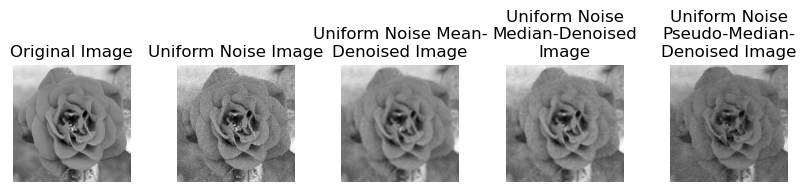

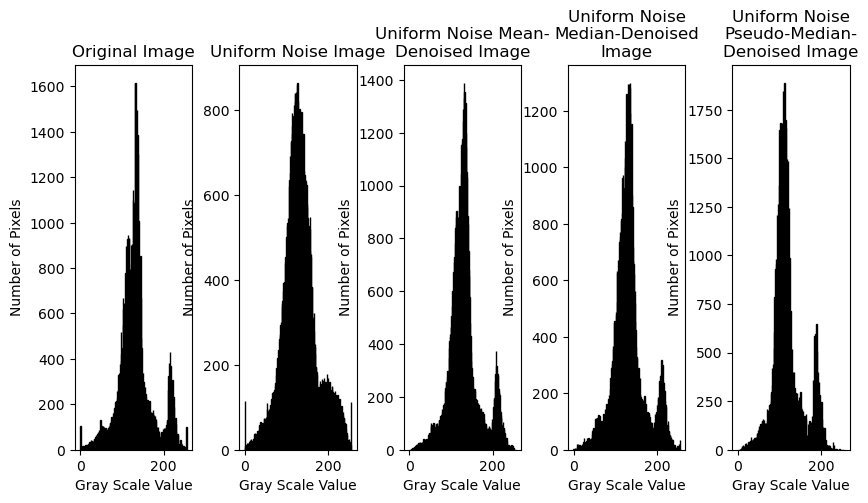

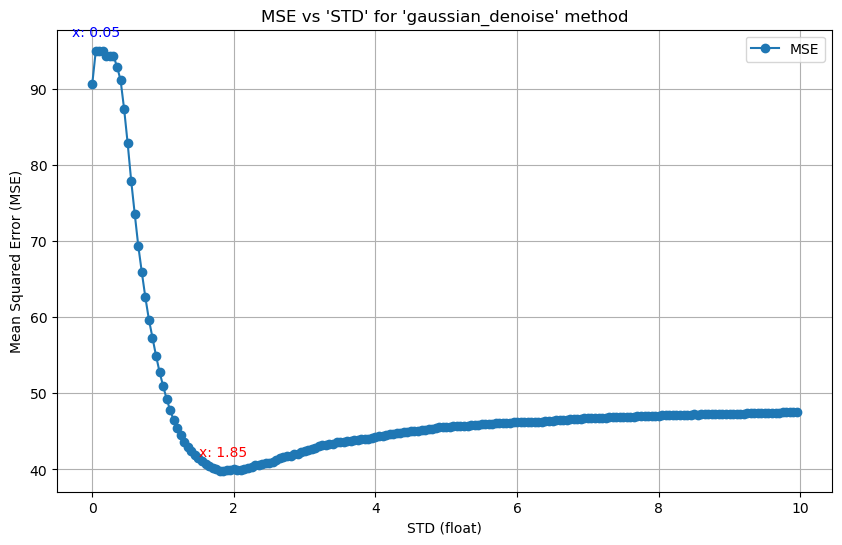

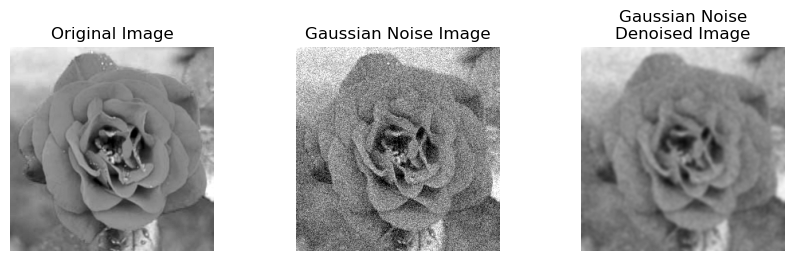

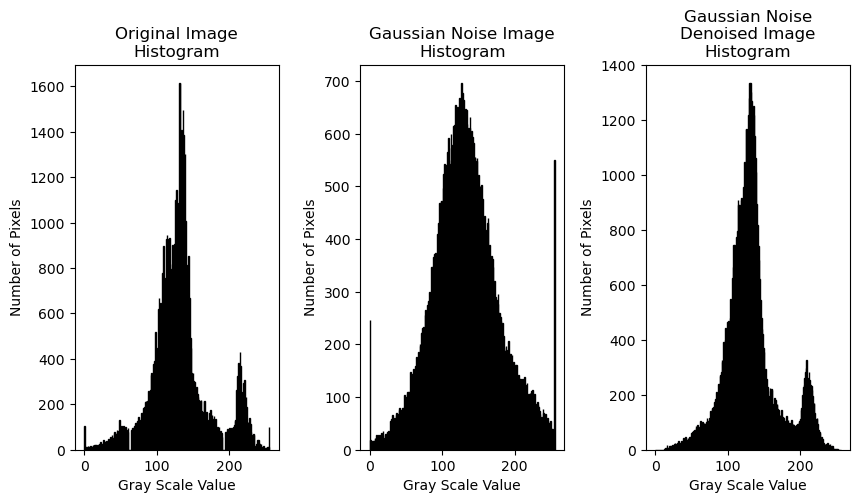

In [8]:
# Gray Scale Noise Removal

## Uniform Noise
rose_original = Image(256, 256, 1)
rose_original.load("images/rose.raw")

rose_uni = Image(256, 256, 1)
rose_uni.load("images/rose_uni.raw")
rose_uni_mean_denoised = Image.mean_denoise(rose_uni, 0, 5)
rose_uni_median_denoised = Image.median_denoise(rose_uni, 0, 5)
rose_uni_pmedian_denoised = Image.median_denoise(rose_uni, 0, 5, pseudo=True)

show_images([rose_original, rose_uni, rose_uni_mean_denoised, rose_uni_median_denoised, rose_uni_pmedian_denoised], ["Original Image", "Uniform Noise Image", "Uniform Noise Mean-Denoised Image", "Uniform Noise Median-Denoised Image", "Uniform Noise Pseudo-Median-Denoised Image"])
plot_histograms([rose_original, rose_uni, rose_uni_mean_denoised, rose_uni_median_denoised, rose_uni_pmedian_denoised], ["Original Image", "Uniform Noise Image", "Uniform Noise Mean-Denoised Image", "Uniform Noise Median-Denoised Image", "Uniform Noise Pseudo-Median-Denoised Image"])

## Gaussian Noise
rose_guassian = Image(256, 256, 1)
rose_guassian.load("images/rose_gau.raw")

tune_param(
    rose_original,
    rose_guassian,
    "gaussian_denoise",
    "STD",
    float,
    np.arange(0, 10, 0.05),
    { "channel": 0, "window_size": 11 },
    0,
)

rose_guassian_denoised = Image.gaussian_denoise(rose_guassian, 0, 11, 1.85)

show_images([rose_original, rose_guassian, rose_guassian_denoised], ["Original Image", "Gaussian Noise Image", "Gaussian Noise Denoised Image"])
plot_histograms([rose_original, rose_guassian, rose_guassian_denoised], ["Original Image Histogram", "Gaussian Noise Image Histogram", "Gaussian Noise Denoised Image Histogram"])

- **Color image**

    Next, I applied denoising to a color image. Compared to grayscale images, denoising color images requires a more complex approach because each color channel needs to be denoised separately. The assignment specifies three types of noise, each requiring one of the following filters: median, Gaussian, or bilateral. After testing, I found that the red channel should be denoised using a median filter, the green channel with a bilateral filter, and the blue channel with a Gaussian filter.

    For the bilateral filter not mentioned earlier, its principle is as follows:

    - **Bilateral Denoise**: This filter takes into account both spatial and color information, with two parameters: `space_STD` and `color_STD`. These two factors together determine the weight of each element in the kernel window, which is then normalized to sum up to 1 for the final weighted average.The bilateral filter essentially combines two Gaussian filters to calculate the weighted sum, considering both spatial and color factors. This approach maintains edges while effectively reducing noise. The formula is as follows:

        $$
        I_{\text{new}}(x, y) = \frac{1}{W_{p}} \sum_{x_{i} \in \Omega} I(x_{i}) f_{r}(\| I(x_{i}) - I(x) \|) g_{s}(\| x_{i} - x \|),
        $$

        where $f_{r}$ is the range kernel based on color similarity, and $g_{s}$ is the spatial kernel based on the Euclidean distance between pixels. To denoise a pixel located at $(i, j)$ in an image, we use the neighboring pixels around it. Let one of these neighboring pixels be located at $(k, l)$. Assuming both the range and spatial kernels are *Gaussian*, the weight assigned to the neighboring pixel $(k, l)$ when denoising the pixel at $(i, j)$ is calculated as:

        $$
        w(i, j, k, l) = \exp \left( -\frac{(i - k)^2 + (j - l)^2}{2\sigma_d^2} - \frac{\|I(i, j) - I(k, l)\|^2}{2\sigma_r^2} \right),
        $$

        Here:
        - $\sigma_d$, which is `space_STD`, controls the influence of the spatial distance between pixels,
        - $\sigma_r$, which is `color_STD` controls the influence of color similarity between pixels.

    Using the `tune_param` function, I found that with a window size of 15, the `color_STD` converges when it reaches around 60. Given this, I also identified an appropriate value for `space_STD`. Using a similar method, I determined the optimal `STD` for the Gaussian filter, allowing me to denoise the image effectively. 

    As shown in the results, most of the noise was successfully removed. However, the overall image appears slightly blurred, which is somewhat unfortunate. Nonetheless, I am quite satisfied with the final outcome.


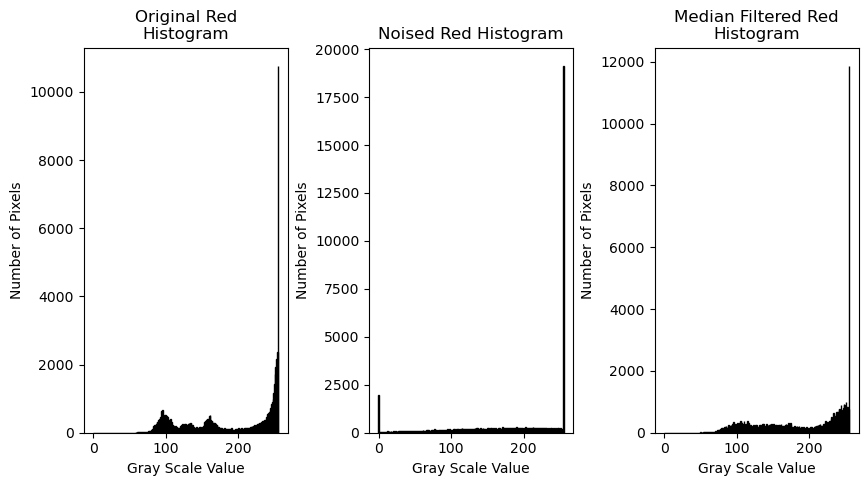

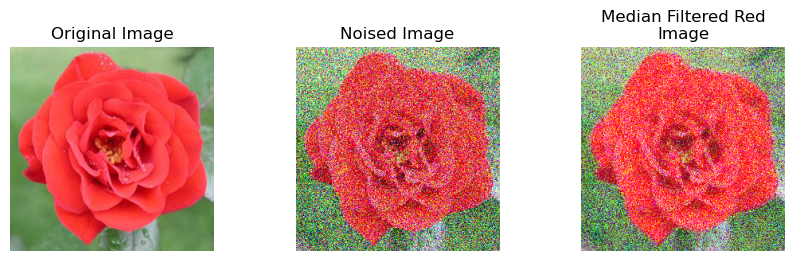

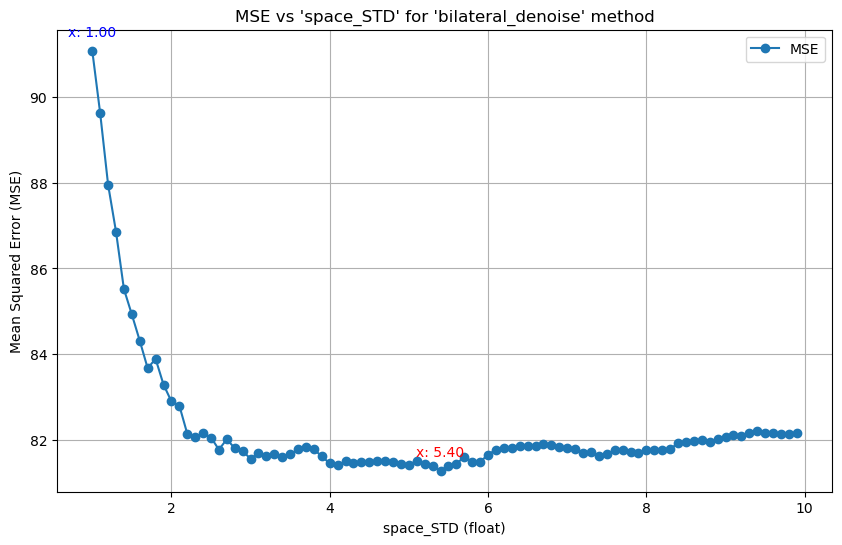

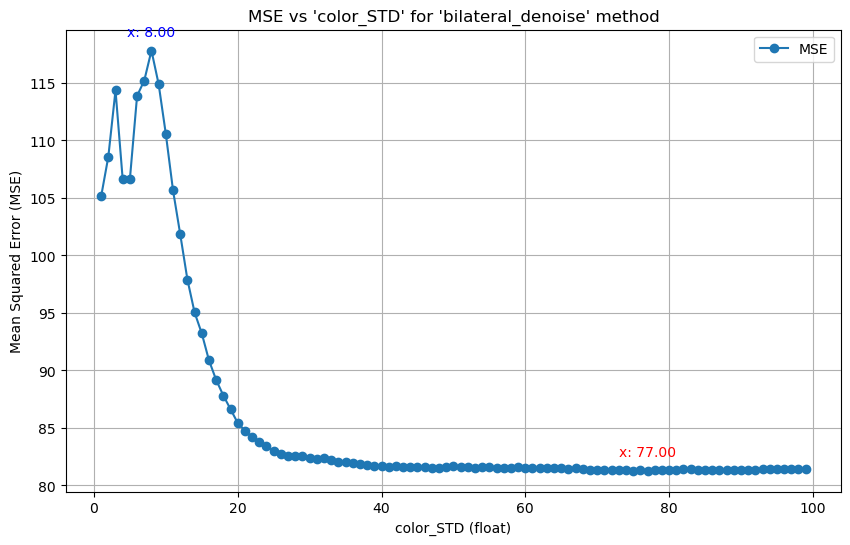

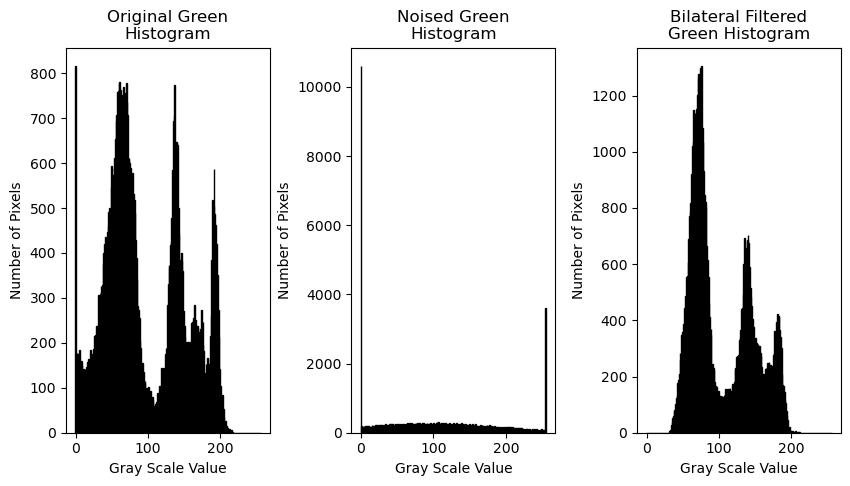

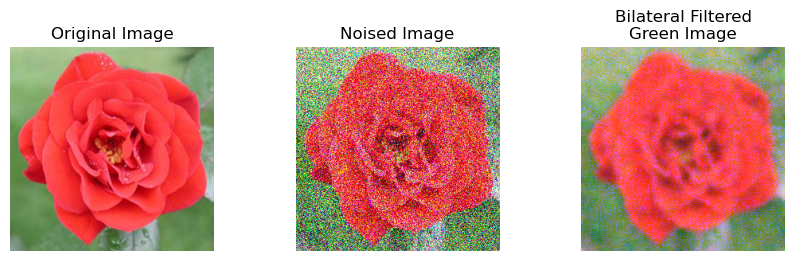

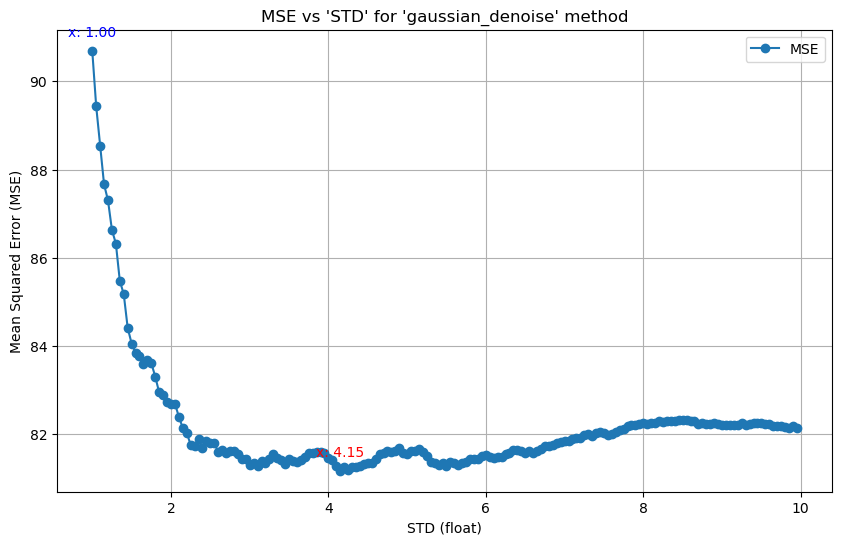

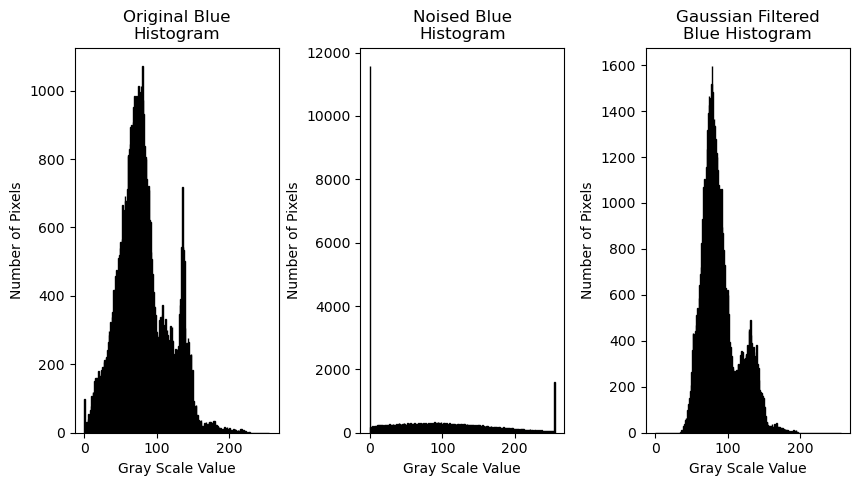

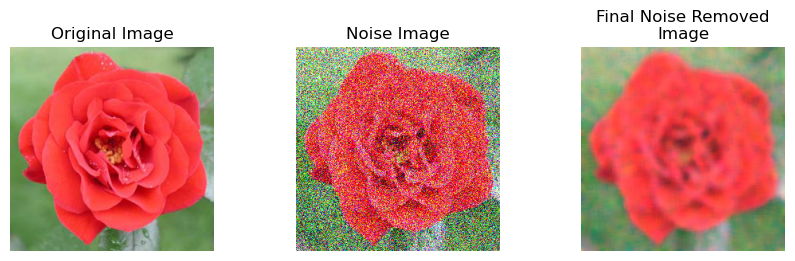

MSE between original noised image and original image: 99.95398457845052
MSE between denoised image and original image: 76.68419392903645


In [9]:
# Colored Noise Removal

rose_color = Image(256, 256, 3)
rose_color.load("images/rose_color.raw")
rose_color_noise = Image(256, 256, 3)
rose_color_noise.load("images/rose_color_noise.raw")

# Red Channel Noise Removal
rose_color_median_red = Image.median_denoise(rose_color_noise, 0, 9, False)
plot_histograms([rose_color, rose_color_noise, rose_color_median_red], ["Original Red Histogram", "Noised Red Histogram", "Median Filtered Red Histogram"])
show_images([rose_color, rose_color_noise, rose_color_median_red], ["Original Image", "Noised Image", "Median Filtered Red Image"])

# Green Channel Noise Removal
tune_param(
    rose_color,
    rose_color_median_red,
    "bilateral_denoise",
    "space_STD",
    float,
    np.arange(1, 10, 0.1),
    { "channel": 1, "window_size": 15, "color_STD": 77.0 },
    1,
)

tune_param(
    rose_color,
    rose_color_median_red,
    "bilateral_denoise",
    "color_STD",
    float,
    np.arange(1, 100, 1),
    { "channel": 1, "window_size": 15, "space_STD": 5.4 },
    1,
)

rose_color_bilateral_green = Image.bilateral_denoise(rose_color_median_red, 1, 15, 5.4, 77.0)
plot_histograms([rose_color, rose_color_noise, rose_color_bilateral_green], ["Original Green Histogram", "Noised Green Histogram", "Bilateral Filtered Green Histogram"], [1, 1, 1])
show_images([rose_color, rose_color_noise, rose_color_bilateral_green], ["Original Image", "Noised Image", "Bilateral Filtered Green Image"])

# Blue Channel Noise Removal
tune_param(
    rose_color,
    rose_color_bilateral_green,
    "gaussian_denoise",
    "STD",
    float,
    np.arange(1, 10, 0.05),
    { "channel": 2, "window_size": 15 },
    2,
)

rose_color_denoise = Image.gaussian_denoise(rose_color_bilateral_green, 2, 15, 4.15)
plot_histograms([rose_color, rose_color_noise, rose_color_denoise], ["Original Blue Histogram", "Noised Blue Histogram", "Gaussian Filtered Blue Histogram"], [2, 2, 2])
show_images([rose_color, rose_color_noise, rose_color_denoise], ["Original Image", "Noise Image", "Final Noise Removed Image"])

# Noise Removal Evaluation
print(f"MSE between original noised image and original image: {compare_images(rose_color, rose_color_noise)}")
print(f"MSE between denoised image and original image: {compare_images(rose_color, rose_color_denoise)}")